In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
events = pd.read_csv("dataset_events.csv")
print(events.shape)
events.head()

(653419, 4)


,customer_id,product_id,type,timestamp
0,1,19685,view_product,1527812004
1,1,19685,view_product,1527812041
2,1,19685,add_to_cart,1527812046
3,1,19685,view_product,1527812048
4,1,19685,view_product,1527812050


<BarContainer object of 3 artists>

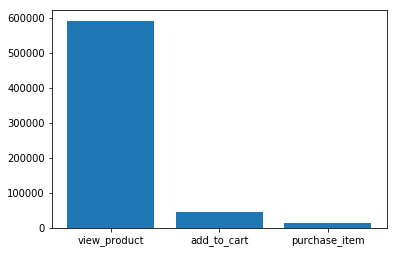

In [3]:
plt.bar(events.type.value_counts().keys(), events.type.value_counts().values)

In [4]:
only_views = events[events.type=="view_product"].drop(columns=['type', 'timestamp'])
grouped_views_by_customer_id = only_views.groupby(['customer_id', 'product_id']).product_id.agg('count').to_frame('n_views').reset_index()
grouped_views_by_customer_id.head()

,customer_id,product_id,n_views
0,1,19685,4
1,2,7953,1
2,3,5156,1
3,3,5157,1
4,4,4633,1


In [5]:
only_cart = events[events.type=="add_to_cart"].drop(columns=['type', 'timestamp'])
grouped_cart_by_customer_id = only_cart.groupby(['customer_id', 'product_id']).product_id.agg('count').to_frame('n_cart').reset_index()
grouped_cart_by_customer_id.head()

,customer_id,product_id,n_cart
0,1,19685,1
1,5,8589,1
2,7,3151,1
3,7,13690,1
4,7,14463,1


In [6]:
only_purchases = events[events.type=="purchase_item"].drop(columns=['type', 'timestamp'])
grouped_purchases_by_customer_id = only_purchases.groupby(['customer_id', 'product_id']).product_id.agg('count').to_frame('n_purchases').reset_index()
grouped_purchases_by_customer_id.head()

,customer_id,product_id,n_purchases
0,10,6963,1
1,22,4209,1
2,22,27912,1
3,43,24413,1
4,44,3814,1


In [7]:
customer_product = events[['customer_id', 'product_id']].drop_duplicates().reset_index(drop=True)
event_counts = pd.merge(customer_product, grouped_views_by_customer_id,  how='left', left_on=['customer_id','product_id'], right_on = ['customer_id','product_id'])
event_counts['n_views'].fillna(0, inplace=True)
event_counts = pd.merge(event_counts, grouped_cart_by_customer_id,  how='left', left_on=['customer_id','product_id'], right_on = ['customer_id','product_id'])
event_counts['n_cart'].fillna(0, inplace=True)
event_counts = pd.merge(event_counts, grouped_purchases_by_customer_id,  how='left', left_on=['customer_id','product_id'], right_on = ['customer_id','product_id'])
event_counts['n_purchases'].fillna(0, inplace=True)
event_counts.head()

,customer_id,product_id,n_views,n_cart,n_purchases
0,1,19685,4.0,1.0,0.0
1,2,7953,1.0,0.0,0.0
2,3,5156,1.0,0.0,0.0
3,3,5157,1.0,0.0,0.0
4,4,21122,4.0,0.0,0.0


In [8]:
print(event_counts['n_views'].sum(), events[events.type=="view_product"].shape)
print(event_counts['n_cart'].sum(), events[events.type=="add_to_cart"].shape)
print(event_counts['n_purchases'].sum(), events[events.type=="purchase_item"].shape)

event_counts.shape, events[['product_id', 'customer_id']].drop_duplicates().shape

592299.0 (592299, 4)
46121.0 (46121, 4)
14999.0 (14999, 4)


((357930, 5), (357930, 2))

In [9]:
event_counts['rating'] = 0

idxs = event_counts[event_counts.n_views == 1].index
event_counts.loc[idxs, 'rating'] = 1

idxs = event_counts[event_counts.n_views > 1].index
event_counts.loc[idxs, 'rating'] = 2

idxs = event_counts[event_counts.n_cart == 1].index
event_counts.loc[idxs, 'rating'] = 3

idxs = event_counts[event_counts.n_cart > 1].index
event_counts.loc[idxs, 'rating'] = 4

idxs = event_counts[event_counts.n_purchases == 1].index
event_counts.loc[idxs, 'rating'] = 5

idxs = event_counts[event_counts.n_purchases > 1].index
event_counts.loc[idxs, 'rating'] = 6
event_counts.head()

,customer_id,product_id,n_views,n_cart,n_purchases,rating
0,1,19685,4.0,1.0,0.0,3
1,2,7953,1.0,0.0,0.0,1
2,3,5156,1.0,0.0,0.0,1
3,3,5157,1.0,0.0,0.0,1
4,4,21122,4.0,0.0,0.0,2


In [96]:
ratings = event_counts.drop(columns=['n_views','n_cart','n_purchases']).reset_index(drop=True)

In [47]:

from lightfm.data import Dataset

dataset = Dataset()
dataset.fit(
    users = set(ratings[:, 0]),
    items = set(ratings[:, 1])
)
_, interactions = dataset.build_interactions(ratings)


In [48]:
def get_sparsity(M):
    matrix_size = M.shape[0]*M.shape[1] 
    num_events = len(M.nonzero()[0])
    sparsity = 100*(1 - (num_events/matrix_size))
    return sparsity

get_sparsity(interactions), interactions.shape, type(interactions), np.max(interactions)

(99.98493715404697, (83762, 28369), scipy.sparse.coo.coo_matrix, 6.0)

In [98]:
min_product_events_count = 50
grouped_events_by_product_id = events.groupby(['product_id']).customer_id.agg('count').to_frame('n_events').reset_index()
products_with_more_than_n_events = grouped_events_by_product_id[grouped_events_by_product_id.n_events>min_product_events_count]
products_with_more_than_n_events = np.array(products_with_more_than_n_events.product_id)

min_customer_events_count = 7
grouped_events_by_customer_id = events.groupby(['customer_id']).product_id.agg('count').to_frame('n_events').reset_index()
customers_with_more_than_n_events = grouped_events_by_customer_id[grouped_events_by_customer_id.n_events>min_customer_events_count]
customers_with_more_than_n_events = np.array(customers_with_more_than_n_events.customer_id)

customers_with_more_than_n_events.shape, products_with_more_than_n_events.shape

filtered_event_counts = event_counts.loc[event_counts.product_id.isin(products_with_more_than_n_events)]
filtered_event_counts = filtered_event_counts.loc[event_counts.customer_id.isin(customers_with_more_than_n_events)]

final_df =  filtered_event_counts.drop(columns=['n_views','n_cart','n_purchases']).reset_index(drop=True)
ratings = final_df.values
ratings.shape

(134444, 3)

In [50]:
len(set(filtered_event_counts.customer_id)), len(set(filtered_event_counts.product_id)), ratings.shape

(17826, 2315, (134444, 3))

In [51]:
dataset = Dataset()
dataset.fit(
    users = set(ratings[:, 0]),
    items = set(ratings[:, 1])
)
_, interactions = dataset.build_interactions(ratings)

get_sparsity(interactions), interactions.shape, type(interactions), np.max(interactions)

(99.67421091671132, (17826, 2315), scipy.sparse.coo.coo_matrix, 6.0)

<h2>Collaborative recommender system</h2>

In [52]:
mappings = dataset.mapping()
user_mapping, item_mapping = mappings[0], mappings[2]
len(item_mapping), len(user_mapping)

(2315, 17826)

In [53]:
from lightfm.cross_validation import random_train_test_split
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
train, test= random_train_test_split(interactions, test_percentage=0.20, random_state=None)

train.shape, test.shape, get_sparsity(train), get_sparsity(test)

((17826, 2315), (17826, 2315), 99.73936921801557, 99.93484169869575)

In [54]:
from scipy.sparse import csr_matrix

rnd = np.array(test.todense()).copy()
np.random.shuffle(rnd)
random = csr_matrix(rnd)
random.shape, get_sparsity(random)

((17826, 2315), 99.93484169869575)

In [55]:
sorted_popular_items_by_purchase = np.load('sorted_popular_items_by_purchase.npy')
sorted_popular_items_by_cart_add = np.load('sorted_popular_items_by_cart_add.npy')
sorted_popular_items_by_views = np.load('sorted_popular_items_by_views.npy')
n_popular = 50
popular = np.zeros(train.shape)
for id in sorted_popular_items_by_views[:n_popular]:
    if id in item_mapping:
        idx = item_mapping[id]
        popular[:, idx] = 1.5
        
for id in sorted_popular_items_by_cart_add[:n_popular]:
    if id in item_mapping:
        idx = item_mapping[id]
        popular[:, idx] = 3.5

for id in sorted_popular_items_by_purchase[:n_popular]:
    if id in item_mapping:
        idx = item_mapping[id]
        popular[:, idx] = 5.5
        
popular = csr_matrix(popular)

In [56]:
model = LightFM(loss='warp', no_components=40)

model.fit_partial(train, epochs=15, verbose=True)

d = {
    "random": random,
    "popular": popular,
    "train": train,
    "test": test,
}
for key in d:
    precision = precision_at_k(model, d[key], k=10, num_threads=4).mean()
    recall = recall_at_k(model, d[key], k=10, num_threads=4).mean()
    f1 = (2*precision*recall)/(precision+recall) #overit
    print("{:10} precision: {:5.4f} recall: {:5.4f} f1: {:4.4f}".format(key, precision, recall, f1))
for key in d:
    auc = auc_score(model, d[key], num_threads=4).mean()
    print("{:10} AUC: {:5.4f}".format(key, auc))


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
random     precision: 0.0043 recall: 0.0203 f1: 0.0070
popular    precision: 0.3753 recall: 0.0458 f1: 0.0816
train      precision: 0.3587 recall: 0.7531 f1: 0.4860
test       precision: 0.0587 recall: 0.3191 f1: 0.0991
random     AUC: 0.5977
popular    AUC: 0.7635
train      AUC: 0.9964
test       AUC: 0.9208


In [57]:
events.head()

,customer_id,product_id,type,timestamp
0,1,19685,view_product,1527812004
1,1,19685,view_product,1527812041
2,1,19685,add_to_cart,1527812046
3,1,19685,view_product,1527812048
4,1,19685,view_product,1527812050


In [58]:
customer_id = 8132
print(events[events.customer_id == customer_id])
all_events = pd.read_csv("dataset_events.csv")
# print(all_events[all_events.customer_id == customer_id])


        customer_id  product_id           type   timestamp
34368          8132       20756   view_product  1527973878
34383          8132       12763   view_product  1527973978
34421          8132       20756   view_product  1527974104
120071         8132       24690   view_product  1528285915
120077         8132       24713   view_product  1528285934
120079         8132       24690   view_product  1528285947
120095         8132       24690   view_product  1528285996
120126         8132       23469   view_product  1528286125
273316         8132       21099   view_product  1528827848
273364         8132       26044   view_product  1528827945
273414         8132       26042   view_product  1528827999
273465         8132       19454   view_product  1528828076
273485         8132       19392   view_product  1528828112
273604         8132       24690   view_product  1528828299
273608         8132       24713   view_product  1528828302
273621         8132       24691   view_product  15288283

In [59]:
# colaboratvie 
# -ak ma produkt viac ako 50 unikatnych videni
# -ak ma user aspon 9 pozretych itemov

# 1. ak user nenavstivil ziadny produky - popularne
# 2. ak user navstivil menej ako 9 itemov - nie je v colab systeme - nevieme vyuzit
#     -zistit najpodobnejsie z navstivenych itemov - ovazit a zoradit
# 3. ak user navstivil aspon 9 itemov
#     -ak maju vsetky itemy aspon 50 zhliadnuti - ok
#     -ak niektore itemy maju 50 zhliadnuti - kombinacia colaborative a similarity - aka ?
#     -ak ziaden item nema aspon 50 zhliadnuti - kombinacia najpodobnejsich - aka ?


In [60]:
for i, r in all_events[all_events.customer_id == customer_id].iterrows():
    print(r.product_id, r.customer_id)

20756 8132
12763 8132
20756 8132
24690 8132
24713 8132
24690 8132
24690 8132
23469 8132
21099 8132
26044 8132
26042 8132
19454 8132
19392 8132
24690 8132
24713 8132
24691 8132
24713 8132
24690 8132
24889 8132
24690 8132
11219 8132
11219 8132
11219 8132
24713 8132
24713 8132
24713 8132
24713 8132
24713 8132
11219 8132
24713 8132
20756 8132
24690 8132
26042 8132
26043 8132
26042 8132
20756 8132
26533 8132
24690 8132
24691 8132
24691 8132
22127 8132
24691 8132
20585 8132
24691 8132
22031 8132
22033 8132
22033 8132
24691 8132
24713 8132
24713 8132
24713 8132
24713 8132
24691 8132
22033 8132
22031 8132
24691 8132
24691 8132
24690 8132


In [61]:
products = pd.read_csv("dataset_catalog.csv")
products.head()

,product_id,category_id,category_path,brand,gender,description,price
0,1,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
1,2,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
2,3,2,Clothes,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
3,4,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
4,5,3,Children|Children's Footwear|Children's Sport ...,Nike,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",23.73


In [27]:
model.predict([0], [0,1])

array([-2.38675213, -1.73203623])

In [153]:
final_df.sample(20).head()

,customer_id,product_id,rating
129381,63767,28207,1
35051,27333,20786,1
72735,38239,11535,2
3566,3887,3502,1
82189,8854,25426,2


In [166]:
user_id = 3887
user_idx = user_mapping[user_id]
product_idxs = np.array(list(item_mapping.values()))
product_ids = np.array(list(item_mapping.keys()))
scores = model.predict([user_idx], list(item_mapping.values()))
sorted_idxs = np.argsort(-scores)[:20]
print(product_ids[sorted_idxs])
ids = product_ids[sorted_idxs]

[22031 22033 22030 16857  2839 20585 22032 16854 26739 16855 20591 26533
 12221 12220 26721 19191 26720  3617 22127 20247]


In [163]:
np.random.shuffle(product_ids)
ids = product_ids[:20]

In [167]:
import requests
similarities = []
for id in ids:
    r = requests.get('http://127.0.0.1:5000/similarity/'+str(ids[0])+'/'+str(id))
    s = r.json()
    print(s)
    similarities.append(s)
print()
print(np.mean(similarities))

1.0
1.0
1.0
0.9994891008174388
0.75
0.9998978201634878
1.0
0.9994891008174388
0.39914752822109767
0.9994891008174388
0.7880983572987973
0.18748527827972372
0.6601842679718364
0.59916650447645
0.39914752822109767
0.5997956403269755
0.39914752822109767
0.8492132152588555
0.2931855827318606
0.39938692098092643

0.7161161737302262
